# XYZLoader TLS Demo

Notebook: Sina Zumstein & Hannah Weiser, 2023

This demo shows how to load a point cloud as scene part, which is then converted to a voxel model by HELIOS++, and scan it with terrestrial laser scanning (TLS). We will use the command-line access of HELIOS++ to run the simulation, and use Python just for displaying the input XMLs and the resulting point clouds.

In [1]:
from IPython.display import Code
from pyhelios.util.xmldisplayer import display_xml, find_playback_dir

In [2]:
import os
os.chdir("..")

## Survey
Let us look at the XML files in the simulation. First, we investigate the survey XML file, `tls_sphere_xyzloader.xml` in `data\surveys\voxels`:

In [3]:
Code(display_xml('data/surveys/voxels/tls_sphere_xyzloader.xml'), language='XML')

<document>

    <survey name="tls_sphere_xyzloader" scene="data/scenes/voxels/sphere_xyzloader.xml#sphere_xyzloader_demo" platform="data/platforms.xml#tripod" scanner="data/scanners_tls.xml#riegl_vz400">
		<leg>
            <platformSettings x="40" y="-10" z="0" onGround="true" />
            <scannerSettings active="true" pulseFreq_hz="100000" verticalAngleMin_deg="-40.0" verticalAngleMax_deg="60.0" scanFreq_hz="120" headRotatePerSec_deg="10.00" headRotateStart_deg="250.0" headRotateStop_deg="380.0" />
        </leg>
    </survey>
</document>

We can see that there is one `leg` element corresponding to the scan position at SP(40, -10). Furthermore, we can see that the `tripod` platform in `data\platforms.xml` is referenced, so let's look at that next.

## Platform

In [4]:
Code(display_xml('python/pyhelios/data/platforms.xml', 'tripod'))

<platform id="tripod" name="TLS Tripod" type="static" drag="0">
		<scannerMount x="0" y="0" z="1.5">
		</scannerMount>
	</platform>

This is a very simple `static` type platform. Note the `scannerMount` parameter, indicating an elevation of 1.5 meters above the ground.

## Scanner
Let us now look at the scanner that is mounted on this platform, the `riegl_vz400`:

In [5]:
Code(display_xml('python/pyhelios/data/scanners_tls.xml', 'riegl_vz400'))

<scanner id="riegl_vz400" name="RIEGL VZ-400" accuracy_m="0.005" beamDivergence_rad="0.0003" headRotatePerSecMax_deg="60" optics="rotating" pulseFreqs_Hz="100000,300000" pulseLength_ns="5" rangeMin_m="1.5" scanAngleMax_deg="120" scanAngleEffectiveMax_deg="50" scanFreqMin_Hz="3" scanFreqMax_Hz="120">
		
		<FWFSettings beamSampleQuality="3" />	
		<beamOrigin x="0" y="0" z="0.2">
			<rot axis="y" angle_deg="0" />
			<rot axis="z" angle_deg="0" />
			<rot axis="x" angle_deg="0" />
		</beamOrigin>
		<headRotateAxis x="0" y="0" z="1" />
		
	</scanner>

We see a lot of scanner-specific settings, including the accuracy (`accuracy_m`), the beam divergence (`beamDivergence_rad`), and a list of possible pulse frequences (`pulseFreq_Hz`). The scanner uses a `rotating` prism as beam deflector, probably a triangular prism. The actual output window mentioned in the [data sheet](http://www.riegl.com/uploads/tx_pxpriegldownloads/10_DataSheet_VZ-400_2017-06-14.pdf) (+60° to -40° = 100°; see image below) is smaller than the maximum output window (2 x 120° = 240°) to avoid that the beam hits another face of the rotating deflector, which would result in scattering in not-well defined directions. In HELIOS, we define the **actual** field of view using the `scanAngleEffectiveMax_deg` and the **maximum** field of view using the `scanAngle_deg`. Because the maximum field of view is usually not provided in the datasheet, we have to have a look at the ratio of effective measurement rate to pulse repetition rate, which is the same as the ratio between `scanAngleEffectiveMax_deg` and `scanAngle_deg`. For the *RIEGL* VZ-400, this ratio is **2.4**, as shown below in an excerpt from the [data sheet](http://www.riegl.com/uploads/tx_pxpriegldownloads/10_DataSheet_VZ-400_2017-06-14.pdf). Therefore, we can compute the maximum field of view as 2.4 times the actual field of view, i.e., 100° x 2.4 = 240°. Because the scan angles in HELIOS are defined as half-angles, we divide by two to get the maximum `scanAngle_deg` of 120°. 

Additionally, we see the `beamOrigin` is set to `0.2` meters in `z`. Adding this to the platform offset, we arrive at a height of 1.7 meters above ground for the laser beam origin. With the `headRotateAxis>`-tag, the axis is defined, around which the scanner head rotates. Here, this is the z-axis.

[<img src="images/VZ400_technical_data.png" alt="excerpt from RIEGL VZ-400 data sheet" width="800"/>](images/VZ400_technical_data.png)

*Source: [RIEGL Laser Measurement Systems](http://riegl.com/) (2017): [RIEGL VZ-400 data sheet](http://www.riegl.com/uploads/tx_pxpriegldownloads/10_DataSheet_VZ-400_2017-06-14.pdf)*

## Scene

Let's take a look at the scene, `sphere_xyzloader_demo` in `data/scenes/voxels/sphere_xyzloader.xml`:

In [6]:
Code(display_xml('data/scenes/voxels/sphere_xyzloader.xml', 'sphere_xyzloader_demo'))

<scene id="sphere_xyzloader_demo" name="sphere xyzloader demo">
        <part>
            <filter type="objloader">
                <param type="string" key="filepath" value="data/sceneparts/basic/groundplane/groundplane.obj" />
            </filter>
            <filter type="scale">
                <param type="double" key="scale" value="100" />
            </filter>
        </part>
        <part>
            <filter type="xyzloader">
                <param type="string" key="filepath" value="data/sceneparts/pointclouds/sphere_dens25000.xyz" />
				<param type="string" key="separator" value=" " />
				<param type="double" key="voxelSize" value="1.0" />
				<!-- Normal estimation using Singular Value Decomposition (SVD)
				MODE 1: simple mode / MODE 2: advanced mode for large files, which works in batches -->
				<param type="int" key="estimateNormals" value="1" />
				<!-- If less than three points fall into one voxel, it is discarded.
				To avoid this, a default Normal can be assigned to these voxels with:
				<param type="vec3" key="defaultNormal" value="0;0;1" /> -->
				<param type="string" key="matfile" value="data/sceneparts/toyblocks/sphere.mtl" />
				<param type="string" key="matname" value="Material.008" />
            </filter>
			<filter type="translate">
				<param type="vec3" key="offset" value="0;0;10" />
			</filter>
		</part>
    </scene>

This scene consits of a simple `groundplane.obj`, which is loaded with the `objloader` filter and a point cloud of a sphere (`sphere_dens25000.xyz`) which is loaded with the `xyzloader` filter. HELIOS++ is transforming this point cloud into a voxel model which is then scanned. The size of the voxels is determined by the value provided to the parameter `voxelSize`, here `1.0` meters.

Furthermore, providing `1` to the `estimateNormals` parameter tells HELIOS to compute normals for each voxels. This means that not the normal vector of the outer surface of each voxel cube is used but instead the normal vector computed from the points within the voxel. These normal vectors determine the incidence angle of the beam which in return influences the intensity that is computed for the generated return.


## Executing the Simulation

Now, we are ready to run the simulation. In Jupyter Notebooks, we can run external commands with the `!command` syntax, but you can also just run it from the command line. The `-q` flag stands for "quiet" and achieves that in the log, only errors are reported.

In [7]:
!helios data/surveys/voxels/tls_sphere_xyzloader.xml "-q"
output_path = find_playback_dir("data/surveys/voxels/tls_sphere_xyzloader.xml")

## The results

Now we can display a 3D plot of the result.

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

print('Loading points from', Path(output_path))

points = np.loadtxt(Path(output_path) / 'leg000_points.xyz')

Loading points from E:\Software\_helios_versions\helios\output\tls_sphere_xyzloader\2024-05-28_18-32-00


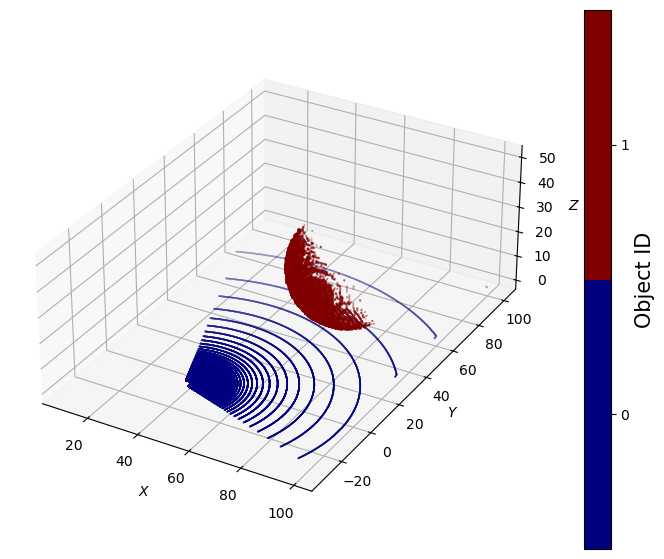

In [9]:
# Matplotlib figures.
fig = plt.figure(figsize=(9,7))

#settings for a discrete colorbar
N=2
cmap=plt.get_cmap('jet',N)

# Scatter plot of the point cloud (coloured by hitObjectId).
ax = fig.add_subplot(projection='3d')
sc = ax.scatter(points[:, 0], points[:, 1], points[:, 2], c=points[:, 8], cmap=cmap, s=0.02, label='scene')

# Add axis labels.
ax.set_xlabel('$X$')
ax.set_ylabel('$Y$')
ax.set_zlabel('$Z$')

# set equal axes
box = (np.ptp(points[:, 0]), np.ptp(points[:, 1]), np.ptp(points[:, 2]))
ax.set_box_aspect(box)  

cbar = plt.colorbar(sc, ticks=[1/4, 3/4])

cbar.set_label('Object ID', fontsize=15)
cbar.ax.set_yticklabels(['0', '1'])

# Display results
plt.show()


Let's look only at the sphere and investigate the intensity values.

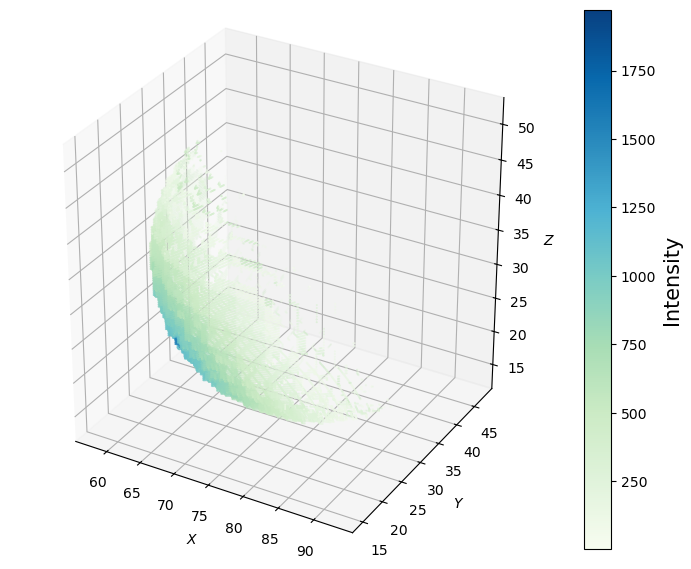

In [10]:
# select only points with object ID = 1
sphere_points = points[points[:, 8] == 1, :]

# Matplotlib figures.
fig = plt.figure(figsize=(9,7))

# Scatter plot of only the sphere point cloud (coloured by Intensity).
ax = fig.add_subplot(projection='3d')
sc = ax.scatter(sphere_points[:, 0], sphere_points[:, 1], sphere_points[:, 2], c=sphere_points[:, 3], cmap="GnBu", s=0.1, label='scene')

# Add axis labels.
ax.set_xlabel('$X$')
ax.set_ylabel('$Y$')
ax.set_zlabel('$Z$')

# set equal axes
box = (np.ptp(sphere_points[:, 0]), np.ptp(sphere_points[:, 1]), np.ptp(sphere_points[:, 2]))
ax.set_box_aspect(box)

cbar = plt.colorbar(sc)

cbar.set_label('Intensity', fontsize=15)

plt.show()

It can be seen that the intensity values are highest in the areas that are closer to the scanner and where the incidence angle of the beam is large (i.e. the beam direction is almost identical to the normal vector of the surface).